# Eye Tracking Analysis - Paper
*by Viviane Clay*

#### Import Dependencies

In [1]:
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import ndimage
import scipy
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Arrow, Circle
from utils import *

#### Specify File Path

In [2]:
path = "./data/"
impath = "C:/Users/vkakerbeck/Dropbox/artstyles/stimuli/"
#impath = "/Users/ingen/Dropbox/artstyles/stimuli/"

### Notes About Data:
Subject 24 has three trials written in one (166)

Subject 38 is missing one trial in fix and blink

Subject 60 has a trial (144) with only one entry at t=-20

In [23]:
def getFixations(data):
    fixationsx = []
    fixationsy = []
    trialnum = []
    tn = 1
    for i in range(len(data)):
        nfixX = []
        nfixY = []
        try:
            for j,fixX in enumerate(data[i].left.fixation.x):
                if data[i].left.fixation.start[j]>6000 and j<len(data[i].left.fixation.start)-1:#check that it isnt just one faulty number but a whole mixed trial
                    data[i].left.fixation.start[j:]=data[i].left.fixation.start[j:]-data[i].left.fixation.start[j]           
                    tn = tn+1
                if data[i].left.fixation.start[j]>0 and data[i].left.fixation.start[j]<6000:
                    nfixX = np.append(nfixX,fixX)
                    nfixY = np.append(nfixY,data[i].left.fixation.y[j])
                    trialnum = np.append(trialnum,tn)
            tn = tn+1
            fixationsx = np.append(fixationsx,np.array(nfixX))
            fixationsy = np.append(fixationsy,np.array(nfixY))
        except:
            print("skipped "+str(i)+"  "+str(j+2))
    return fixationsx,fixationsy,trialnum

def getTrialFixations(data):
    fixationsx = []
    fixationsy = []
    trialnum = []
    blocks = []
    groups = []
    styles = []
    tn = 1
    for i in range(len(data)):
        nfixX = []
        nfixY = []
        try:
            splitp = 0
            for j,fixX in enumerate(data[i].left.fixation.x):
                if data[i].left.fixation.start[j]>6000 and j<len(data[i].left.fixation.start)-1:#check that it isnt just one faulty number but a whole mixed trial
                    data[i].left.fixation.start[j:]=data[i].left.fixation.start[j:]-data[i].left.fixation.start[j]           
                    tn = tn+1
                    splitp = j
                if data[i].left.fixation.start[j]>0 and data[i].left.fixation.start[j]<6000:
                    nfixX = np.append(nfixX,fixX)
                    nfixY = np.append(nfixY,data[i].left.fixation.y[j])
                    trialnum = np.append(trialnum,tn)
            tn = tn+1
            fixationsx = np.append(fixationsx,np.array(nfixX))
            fixationsy = np.append(fixationsy,np.array(nfixY))
            if splitp==0:
                blocks = np.append(blocks,np.full(len(nfixX),int(data[i].block.msg)))
                groups = np.append(groups,np.full(len(nfixX),int(data[i].group.msg)))
                styles = np.append(styles,np.full(len(nfixX),int(data[i].style.msg)))
            else:
                if data[i].left.fixation.start[0]>0:
                    n = 0
                else:
                    n = np.argmin(data[i].left.fixation.start<=0)#get first index where fixation time is >0
                blocks = np.append(blocks,np.full(len(data[i].left.fixation.start[n:splitp]),int(data[i].block.msg[0])))
                blocks = np.append(blocks,np.full(len(data[i].left.fixation.start[splitp+1:]),int(data[i].block.msg[1])))
                groups = np.append(groups,np.full(len(data[i].left.fixation.start[n:splitp]),int(data[i].group.msg[0])))
                groups = np.append(groups,np.full(len(data[i].left.fixation.start[splitp+1:]),int(data[i].group.msg[1])))
                styles = np.append(styles,np.full(len(data[i].left.fixation.start[n:splitp]),int(data[i].style.msg[0])))
                styles = np.append(styles,np.full(len(data[i].left.fixation.start[splitp+1:]),int(data[i].style.msg[1])))
        except:
            print("skipped "+str(i)+"  "+str(j+2))
    return fixationsx,fixationsy,trialnum,blocks,groups,styles

def getBlinks(data):
    blinks = []
    trialnum = []
    tn = 1
    for i in range(len(data)):
        bls = []
        split = False
        if isinstance(data[i].left.blink.start,int):
            if data[i].left.blink.start>6000:
                bls = np.append(bls,0)
                trialnum = np.append(trialnum,tn)
                tn = tn+1
                split = True
            if data[i].left.blink.start<0:
                bls = np.append(bls,0)
                trialnum = np.append(trialnum,tn)
            if data[i].left.blink.start>=0 and data[i].left.blink.start<6000:
                bls = np.append(bls,data[i].left.blink.start)
                trialnum = np.append(trialnum,tn)                
        else:            
            for j in range(len(data[i].left.blink.start)):
                if data[i].left.blink.start[j]>6000 and j<len(data[i].left.blink.start):
                    data[i].left.blink.start[j:]=data[i].left.blink.start[j:]-(data[i].left.blink.start[j]+1)
                    data[i].left.blink.end[j:]=data[i].left.blink.end[j:]-(data[i].left.blink.end[j]+1)
                    tn = tn+1
                    split = True
                if data[i].left.blink.start[j]>=0 and data[i].left.blink.start[j]<6000:
                    bls = np.append(bls,data[i].left.blink.start[j])
                    trialnum = np.append(trialnum,tn)
                if data[i].left.blink.start[j]<0:
                    bls = np.append(bls,0)
                    trialnum = np.append(trialnum,tn)
        if np.any(data[i].left.fixation.start>6000) and split == False:#case when cells were merged but second trial had no blinks
            tn = tn+1
            bls = np.append(bls,0)
            trialnum = np.append(trialnum,tn)
        tn = tn+1
        blinks = np.append(blinks,np.array(bls))
    return blinks,trialnum

# Data Exploration

skipped 143  4


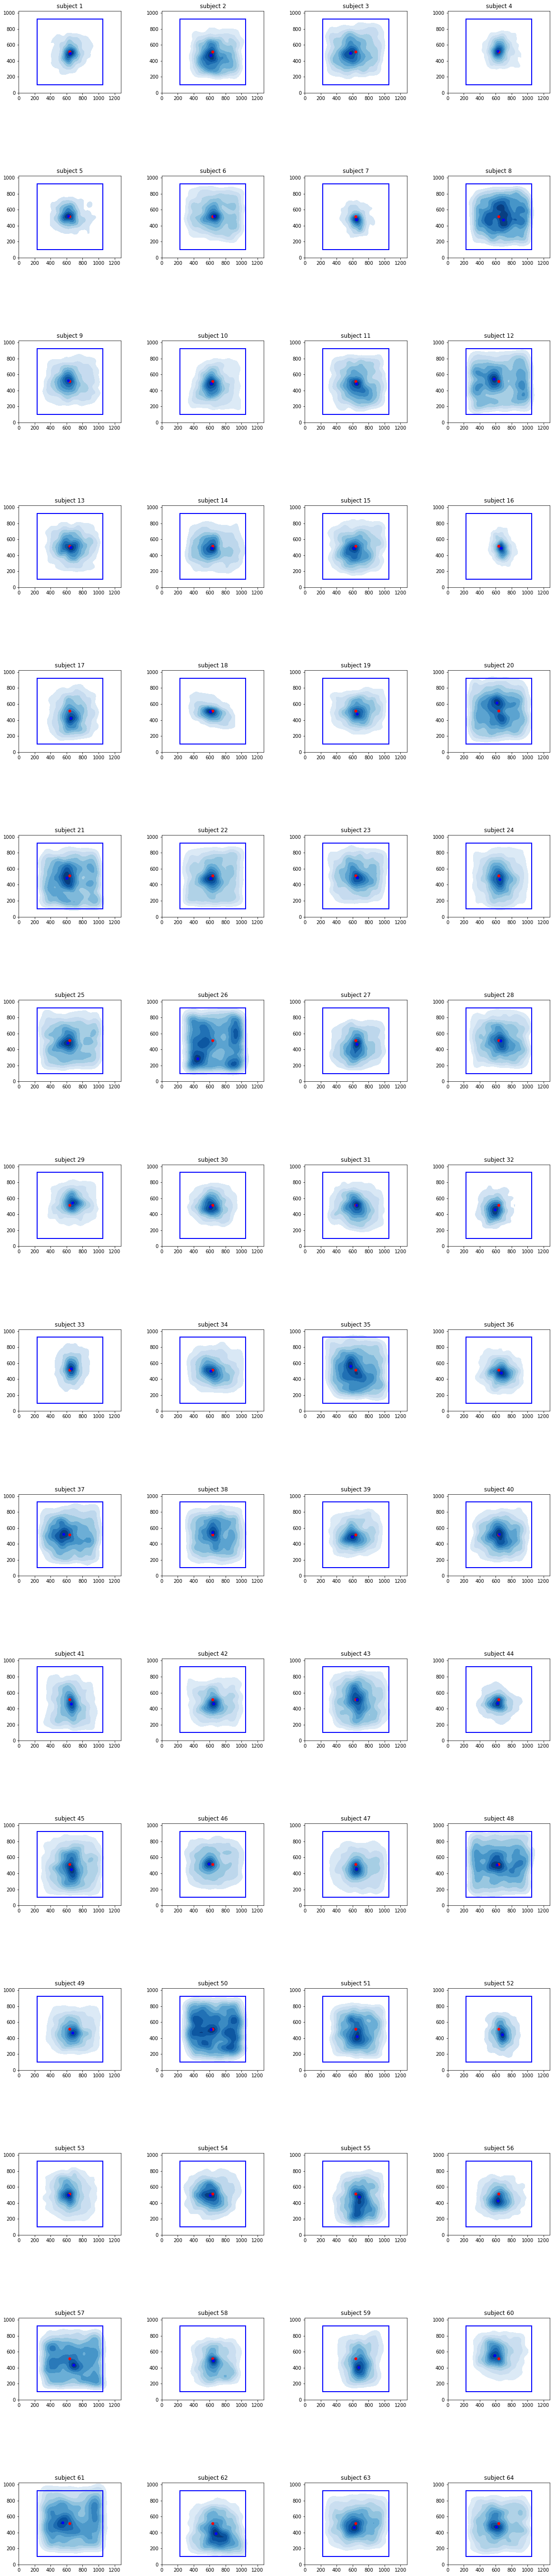

In [11]:
fig = plt.figure(figsize=(20,100))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
biasx = []
biasy = []
for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t = getFixations(data)
    
    xy = np.vstack([fx,fy])
    kde = scipy.stats.gaussian_kde(xy)
    density = kde(xy)
    dx,dy = xy.T[np.argmax(density)]
    
    biasx = np.append(biasx,1280/2-dx)
    biasy = np.append(biasy,1024/2-dy)
    
    ax = fig.add_subplot(16, 4, s+1)
    ax.set_title("subject "+str(s+1))
    plt.xlim(0,1280)
    plt.ylim(0,1024)
    ax.set(aspect="equal")

    sns.kdeplot(fx, fy, shade=True, shade_lowest = False,ax=ax, cmap="Blues")#shade=True,
    
    plt.plot([228, 228],[100, 924], linewidth=2, color='b')
    plt.plot([1052, 1052],[100, 924], linewidth=2, color='b')
    plt.plot([228, 1052],[100, 100], linewidth=2, color='b')
    plt.plot([228, 1052],[924, 924], linewidth=2, color='b')
    ax.add_patch(Circle((1280/2, 1024/2), radius=15, color='red'))
    ax.add_patch(Circle((dx,dy), radius=15, color='blue'))
    

#plt.savefig('ResultsNew/SubjectHeatmaps.png')

skipped 143  4


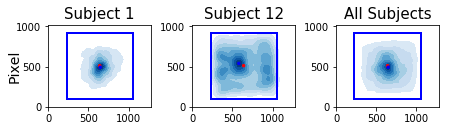

In [24]:
fig = plt.figure(figsize=(7,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
biasx = []
biasy = []
for i,s in enumerate([0,11]):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t = getFixations(data)
    
    xy = np.vstack([fx,fy])
    kde = scipy.stats.gaussian_kde(xy)
    density = kde(xy)
    dx,dy = xy.T[np.argmax(density)]
    
    biasx = np.append(biasx,1280/2-dx)
    biasy = np.append(biasy,1024/2-dy)
    
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title("Subject "+str(s+1), fontsize=15)
    plt.xlim(0,1280)
    plt.ylim(0,1024)
    ax.set(aspect="equal")
    if i == 0:
        ax.set_ylabel('Pixel', fontsize=14,labelpad=-5)

    sns.kdeplot(fx, fy, shade=True, shade_lowest = False,ax=ax, cmap="Blues")#shade=True,
    
    plt.plot([228, 228],[100, 924], linewidth=2, color='b')
    plt.plot([1052, 1052],[100, 924], linewidth=2, color='b')
    plt.plot([228, 1052],[100, 100], linewidth=2, color='b')
    plt.plot([228, 1052],[924, 924], linewidth=2, color='b')
    ax.add_patch(Circle((1280/2, 1024/2), radius=15, color='red'))
    ax.add_patch(Circle((dx,dy), radius=15, color='blue'))

allfixX = []
allfixY = []
XVars = []
YVars = []

for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t = getFixations(data)
    Keep = (fx>200) & (fx<1100) & (fy<1000) & (fy>0)
    t = t[Keep]
    fx = fx[Keep]
    fy = fy[Keep]
    
    allfixX = np.append(allfixX,fx)
    allfixY = np.append(allfixY,fy)
    
    XVars = np.append(XVars,np.var(fx))
    YVars = np.append(YVars,np.var(fy))
xy = np.vstack([allfixX,allfixY])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
dx,dy = xy.T[np.argmax(density)]

biasx = 1280/2-dx
biasy = 1024/2-dy

ax = fig.add_subplot(1, 3, 3)
ax.set_title("All Subjects", fontsize=15)
plt.xlim(0,1280)
plt.ylim(0,1024)
ax.set(aspect="equal")

sns.kdeplot(allfixX, allfixY, shade=True, shade_lowest = False,ax=ax, cmap="Blues")#shade=True,

plt.plot([228, 228],[100, 924], linewidth=2, color='b')
plt.plot([1052, 1052],[100, 924], linewidth=2, color='b')
plt.plot([228, 1052],[100, 100], linewidth=2, color='b')
plt.plot([228, 1052],[924, 924], linewidth=2, color='b')
ax.add_patch(Circle((1280/2, 1024/2), radius=15, color='red'))
ax.add_patch(Circle((dx,dy), radius=15, color='blue'))
    
#plt.show()
plt.savefig('ResultsNew/SubjectHeatmapsExp.tiff', bbox_inches='tight',dpi=500)

## Plot the Fixation Density Map Over all Subjects

skipped 143  4


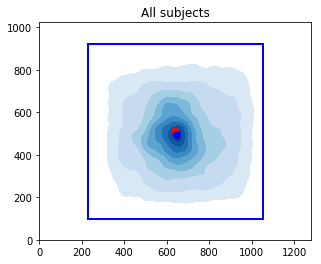

In [5]:
allfixX = []
allfixY = []
XVars = []
YVars = []

for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t = getFixations(data)
    Keep = (fx>200) & (fx<1100) & (fy<1000) & (fy>0)
    t = t[Keep]
    fx = fx[Keep]
    fy = fy[Keep]
    
    allfixX = np.append(allfixX,fx)
    allfixY = np.append(allfixY,fy)
    
    XVars = np.append(XVars,np.var(fx))
    YVars = np.append(YVars,np.var(fy))
fig = plt.figure()
xy = np.vstack([allfixX,allfixY])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
dx,dy = xy.T[np.argmax(density)]

biasx = 1280/2-dx
biasy = 1024/2-dy

ax = fig.add_subplot(1, 1, 1)
ax.set_title("All subjects")
plt.xlim(0,1280)
plt.ylim(0,1024)
ax.set(aspect="equal")

sns.kdeplot(allfixX, allfixY, shade=True, shade_lowest = False,ax=ax, cmap="Blues")#shade=True,

plt.plot([228, 228],[100, 924], linewidth=2, color='b')
plt.plot([1052, 1052],[100, 924], linewidth=2, color='b')
plt.plot([228, 1052],[100, 100], linewidth=2, color='b')
plt.plot([228, 1052],[924, 924], linewidth=2, color='b')
ax.add_patch(Circle((1280/2, 1024/2), radius=15, color='red'))
ax.add_patch(Circle((dx,dy), radius=15, color='blue'))
plt.savefig('ResultsNew/SubjectHeatmaps.tiff', bbox_inches='tight')

### Load Heatmaps

In [13]:
heatmaps = np.load('heatmaps.npy')
blockdist = np.load('blockdist.npy')

In [14]:
np.mean(np.sum(heatmaps.reshape((8,8,30,100)),axis=-1))/8

16.130078125

## Plot Some Samples

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


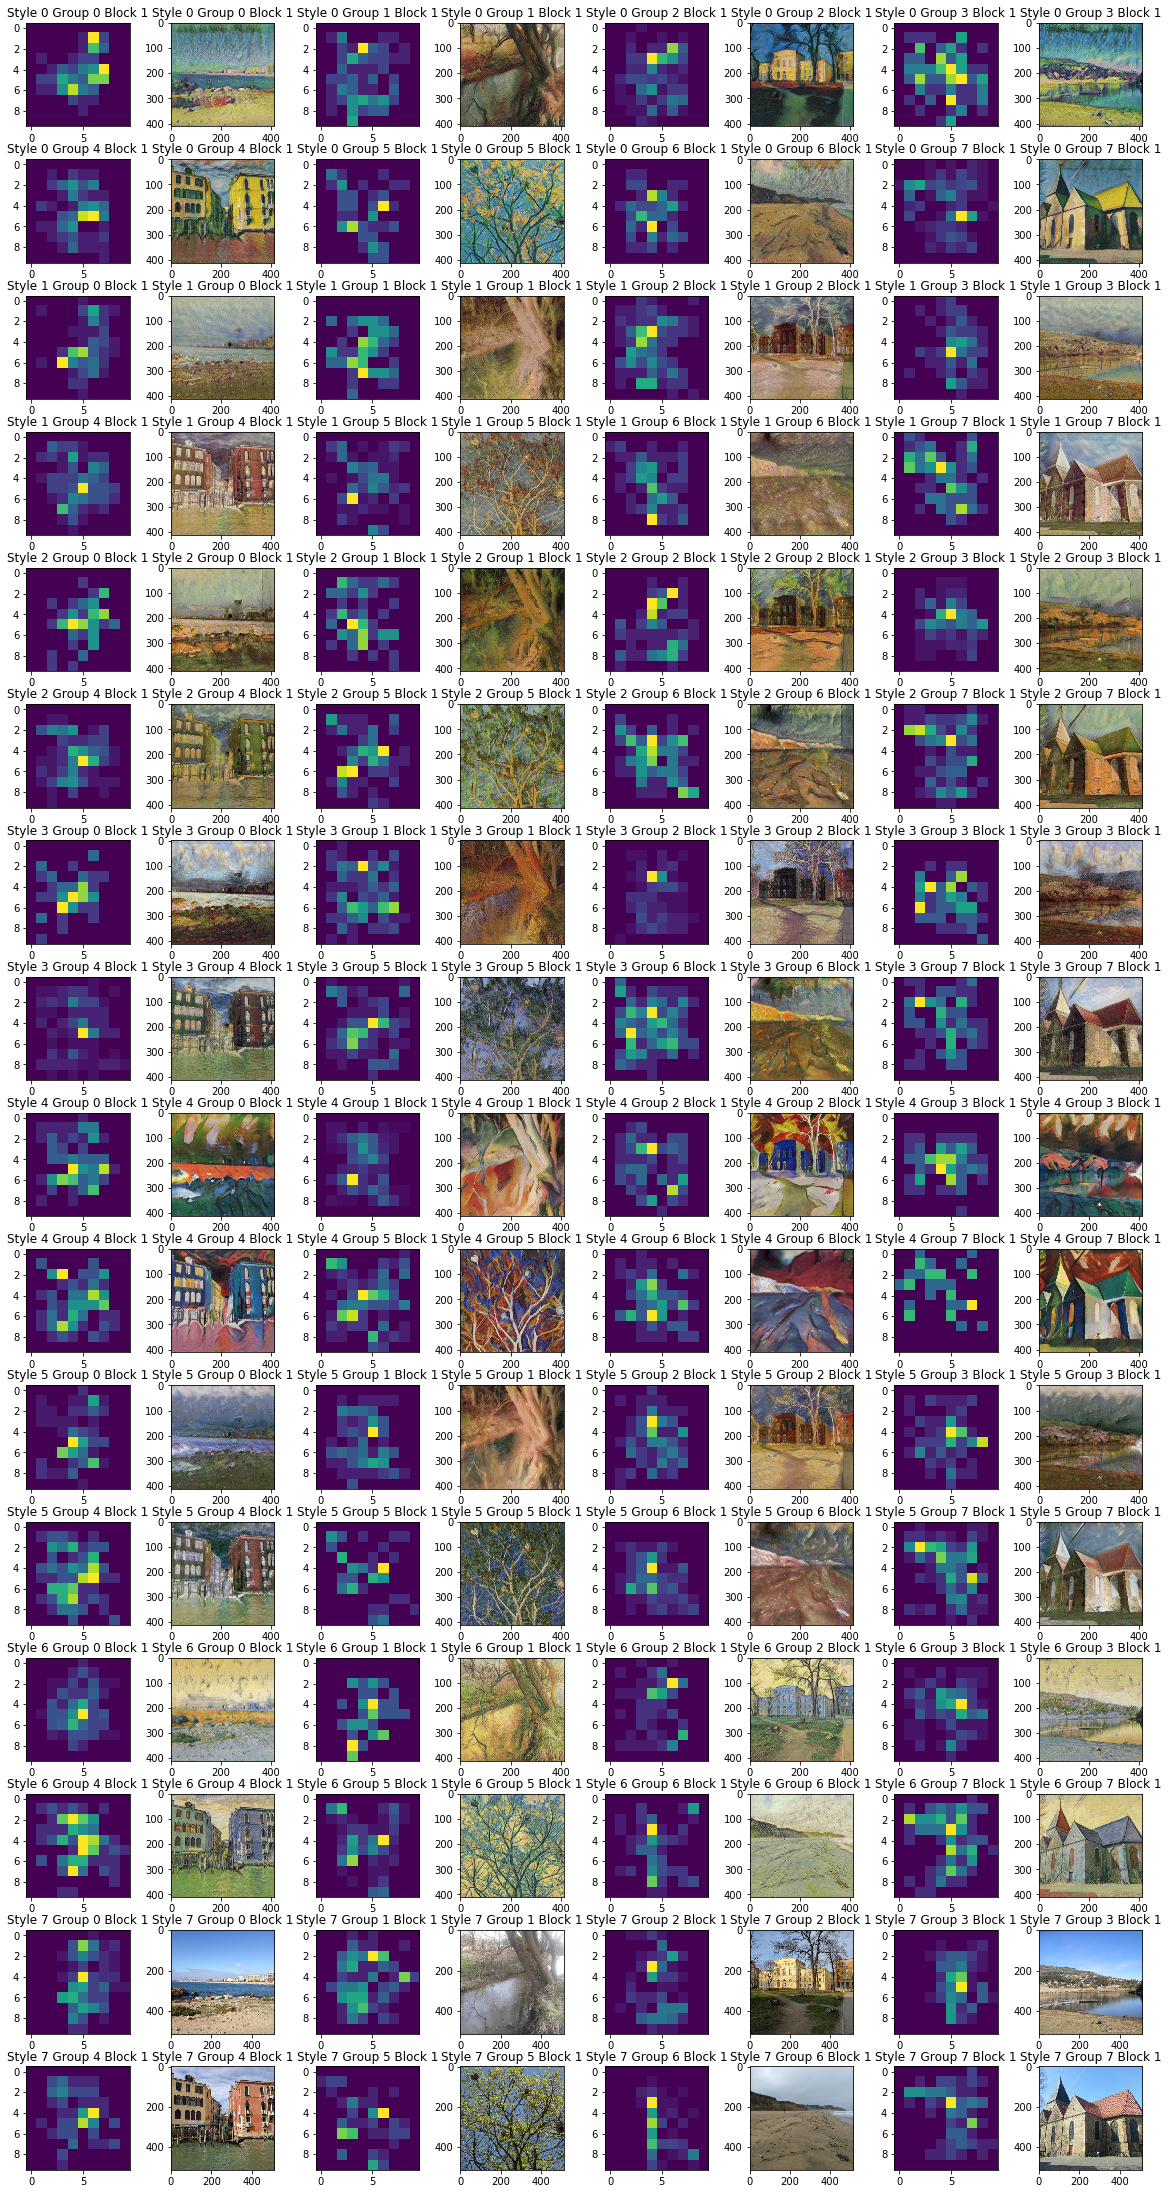

In [6]:
fig = plt.figure(figsize=(20,40))
fig.subplots_adjust(hspace=0.04, wspace=0.4)
n = 1
for s in range(8):
    for g in range(8):
        for b in range(1):
            ax = fig.add_subplot(2*8, 8, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            plt.imshow(heatmaps[s][g][b])
            n = n+1
            ax = fig.add_subplot(2*8, 8, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            im = scipy.ndimage.imread(impath+str(s)+"/"+str(g)+"/"+str(b+1)+".jpg")
            plt.imshow(im)
            n = n+1
plt.show()
#plt.savefig('Results/HeatmapSamples.png', bbox_inches='tight')

### Plot Heat Maps for One Motive

In [15]:
import math
def normalize(data):  
    #norm = np.linalg.norm(data.flatten())
    norm = np.sum(data.flatten())
    normalized = data.flatten()/norm
    return normalized.reshape(data.shape)
def Correlate(h1,h2):
    corr = scipy.stats.pearsonr(h1.flatten(),h2.flatten())
    if math.isnan(corr[0]):
        print((h1).flatten())
        print((h2).flatten())
        return [float(0)]
    return corr
def Differences(h1,h2):
    a = normalize(h1).flatten()
    b = normalize(h2).flatten()
    return np.linalg.norm(a-b)
def normalizeOld(data):
    xmax, xmin = data.max(), data.min()
    out = (data - xmin)/(xmax - xmin)
    return out
def getFixations(s,bl,gr):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t,b,g,st = getTrialFixations(data)
    PickRange = np.where((b==bl) & (g==gr))
    #print(st[PickRange])

    style = np.unique(st[PickRange])#1-8
    group = np.unique(g[PickRange])#0-7
    block = np.unique(b[PickRange])#1-30
    return fx[PickRange],fy[PickRange]

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


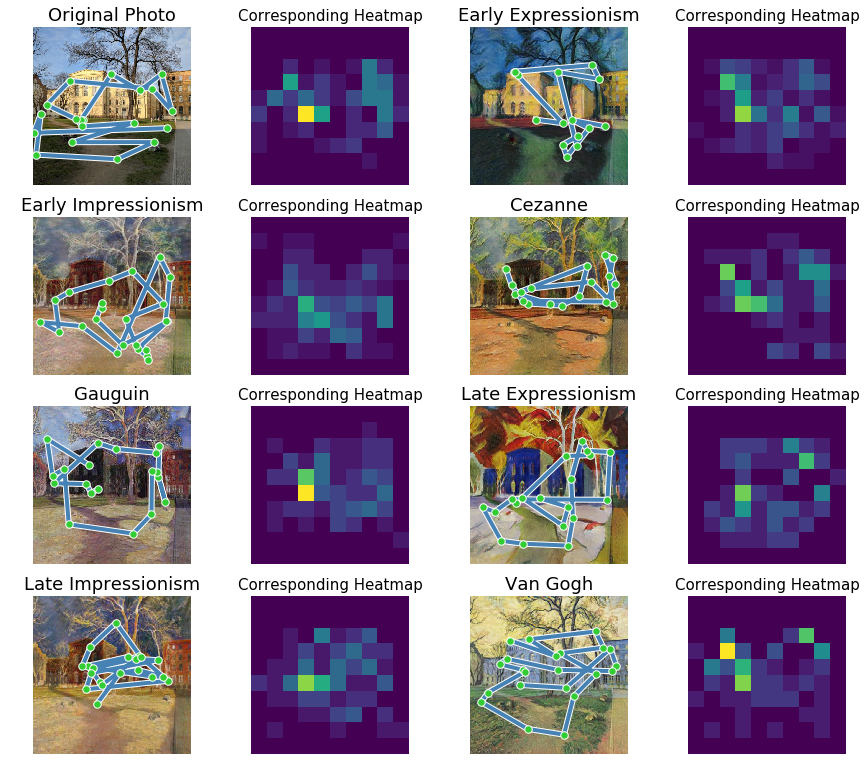

In [7]:
fig = plt.figure(figsize=(15,25))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
styles = ['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Original Photo']
n = 1
subjects = [6,1,18,0,39,3,12,2]

for g in range(1):
    g = 2
    for b in range(1):
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            if n == 15:
                ax = fig.add_subplot(8, 4, 1)
            else:
                ax = fig.add_subplot(8, 4, n+2)
            ax.set_title(styles[s], fontsize=18)
            im = scipy.ndimage.imread(impath+str(s)+"/"+str(g)+"/"+str(b+1)+".jpg")
            plt.imshow(im,extent=(228,1052,100,924))
            fx,fy = getFixations(subjects[s],b+1,g)

            plt.plot(fx,fy,linewidth=6,c='white')
            plt.plot(fx,fy,linewidth=4,c='steelblue',marker='.',mec='white',mfc='limegreen',ms=15)
            plt.axis('off')
            n = n+1 
            if n == 16:
                ax = fig.add_subplot(8, 4, 2)
            else:
                ax = fig.add_subplot(8, 4, n+2)
            ax.set_title("Corresponding Heatmap", fontsize=15)
            pictureHM[s] = normalize(heatmaps[s][g][b])
            plt.imshow(np.rot90(pictureHM[s]),vmin=0,vmax=0.12)
            #plt.colorbar()
            plt.axis('off')
            n = n+1
#plt.suptitle("Normalized Heatmaps Over Subjects for One Base Photo",fontsize=20)
plt.subplots_adjust(top=0.95)
#plt.show()
plt.savefig('ResultsNew/ImageHeatmapExamplePath.tiff', bbox_inches='tight',dpi=500)

# Image Comparison of Example Image

In [16]:
differencesAll = np.zeros((8,8,240))
differencesSumAll = np.zeros((8,8,240))
DotAll = np.zeros((8,8,240))
corrAll = np.zeros((8,8,1))
HeatAll = normalize(np.sum(np.sum(np.sum(heatmaps,axis=1),axis=1),axis=0))
n = 0
for g in range(1):
    g = 2
    for b in range(1):
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
        for i in range(8):
            for j in range(8):
                #differencesAll[i,j,n] = Differences(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)# same as above and substract grand total such that integral of difference is 0
                #differencesSumAll[i,j,n] = np.sum(normalize(pictureHM[i])-normalize(pictureHM[j]))
                #DotAll[i,j,n] = np.dot((normalize(pictureHM[i])-HeatAll).flatten(),(normalize(pictureHM[j])-HeatAll).flatten())
                corr = np.arctanh(Correlate(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)[0])
                if corr == 0:
                    print("Group:"+str(g)+" Block: "+str(b)+" Style "+str(s)+"i "+str(i)+" j "+str(j))
                corrAll[i,j,n] = corr
                #calulate correlation and fisher z-transform, calculate mean, then transform back
        n = n+1

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in arctanh


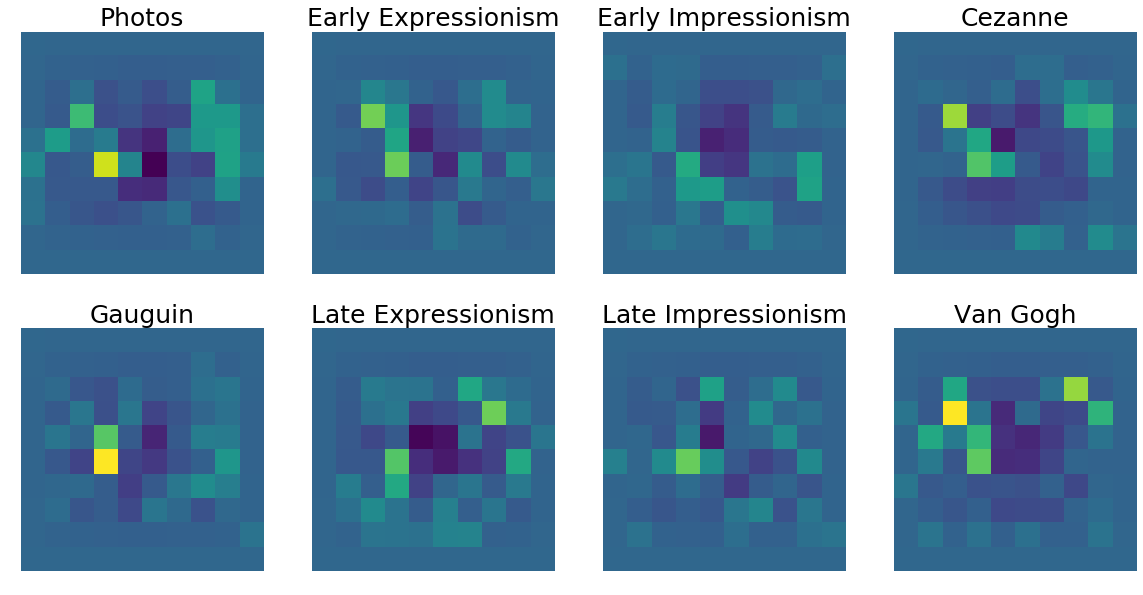

In [17]:
styles = ['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos']
fig = plt.figure(figsize=(20,10))
#plt.suptitle("Normalized Fixations for One Base Photo After Subtracting the Total Bias",fontsize=25)
stylesHeat = np.zeros((8,10,10))
for s in range(8):
    for g in range(1):
        g = 2
        for b in range(1):
            stylesHeat[s] = stylesHeat[s]+heatmaps[s][g][b]
    if s == 7:
        ax = fig.add_subplot(2,4, 1)
    else:
        ax = fig.add_subplot(2,4, s+2)
    #ax = fig.add_subplot(2,4, s+1)
    ax.set_title(str(styles[s]),fontsize=25)
    plt.imshow(np.rot90(normalize(stylesHeat[s])-HeatAll),vmin=-0.05,vmax=0.1)
    plt.axis('off')
    #plt.colorbar()
plt.savefig('ResultsNew/StyleFixExample.tiff', bbox_inches='tight',dpi=500)
#plt.show()

## Correlation Matrix

In [18]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
# For use of "viscm view"
test_cm = parula_map

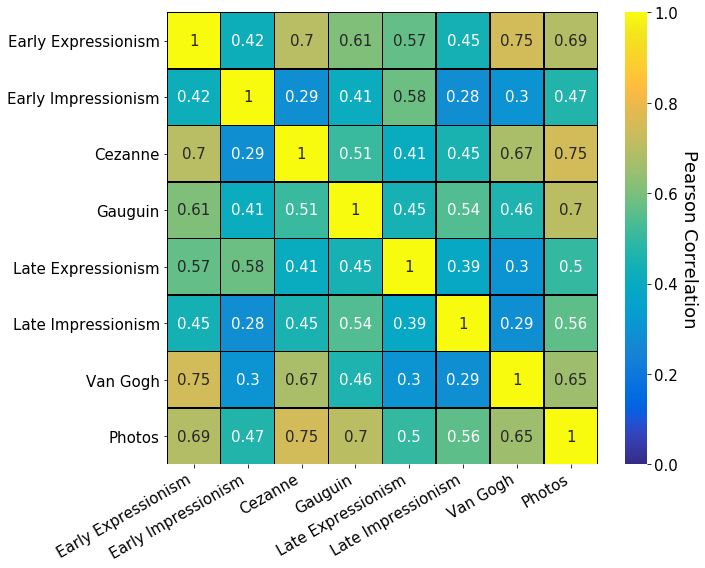

In [19]:
analyze = np.tanh(np.mean(corrAll,axis=2))#[:,:,0]
df2 = pd.DataFrame(analyze, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df2, linewidths=.5, ax=ax,vmin=0,vmax=1,annot=True, cmap=test_cm, linecolor='black', fmt='.2g', annot_kws={"size": 15})

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos']
                   ,fontsize=15,rotation=30, ha="right")
plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Pearson Correlation', rotation=270,labelpad=20,fontsize=18)
#plt.title("Correlation Between Fixations on Artsyles - One Image",fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('ResultsNew/StyleFixCorr1Img.tiff', bbox_inches='tight',dpi=500)

# Image Comparison over All Images

In [20]:
differencesAll = np.zeros((8,8,240))
differencesSumAll = np.zeros((8,8,240))
DotAll = np.zeros((8,8,240))
corrAll = np.zeros((8,8,240))
HeatAll = normalize(np.sum(np.sum(np.sum(heatmaps,axis=1),axis=1),axis=0))
n = 0
for g in range(8):
    for b in range(30):
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
        for i in range(8):
            for j in range(8):
                #differencesAll[i,j,n] = Differences(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)# same as above and substract grand total such that integral of difference is 0
                #differencesSumAll[i,j,n] = np.sum(normalize(pictureHM[i])-normalize(pictureHM[j]))
                #DotAll[i,j,n] = np.dot((normalize(pictureHM[i])-HeatAll).flatten(),(normalize(pictureHM[j])-HeatAll).flatten())
                corr = np.arctanh(Correlate(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)[0])
                if corr == 0:
                    print("Group:"+str(g)+" Block: "+str(b)+" Style "+str(s)+"i "+str(i)+" j "+str(j))
                corrAll[i,j,n] = corr
                #calulate correlation and fisher z-transform, calculate mean, then transform back
        n = n+1

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in arctanh


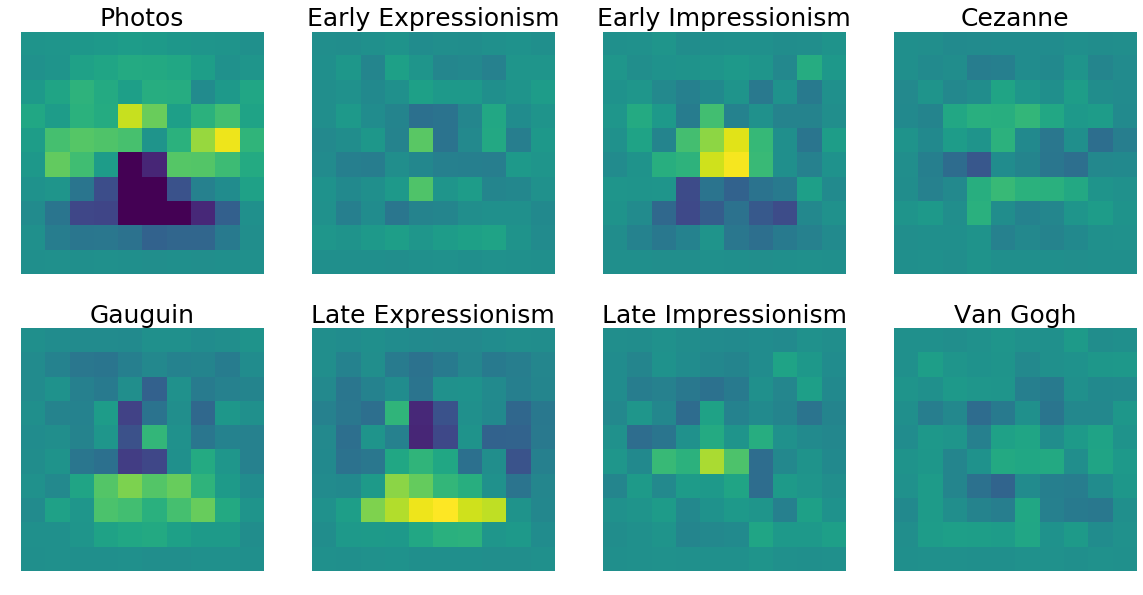

In [21]:
styles = ['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos']
fig = plt.figure(figsize=(20,10))
#plt.suptitle("Normalized Fixations for All Images After Subtracting the Total Bias",fontsize=25)
stylesHeat = np.zeros((8,10,10))
for s in range(8):
    for g in range(8):
        for b in range(30):
            stylesHeat[s] = stylesHeat[s]+(normalize(heatmaps[s][g][b])-HeatAll)
    if s == 7:
        ax = fig.add_subplot(2,4, 1)
    else:
        ax = fig.add_subplot(2,4, s+2)
    #ax = fig.add_subplot(2,4, s+1)
    ax.set_title(str(styles[s]),fontsize=25)
    plt.imshow(np.rot90(stylesHeat[s]),vmin=-1.5,vmax=1.5)
    plt.axis('off')
    #plt.colorbar()
plt.savefig('ResultsNew/StyleFixAll.tiff', bbox_inches='tight',dpi=500)
#plt.show()

## Correlation Matrix

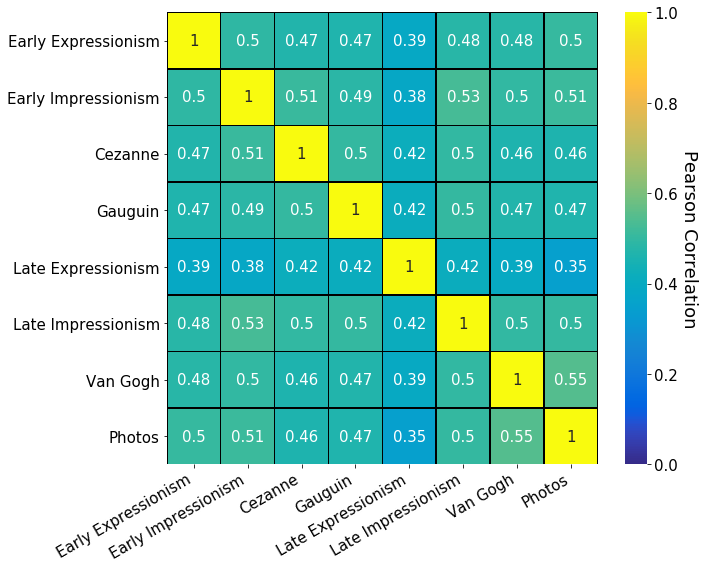

In [22]:
analyze = np.tanh(np.mean(corrAll,axis=2))#[:,:,0]
df2 = pd.DataFrame(analyze, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df2, linewidths=.5, ax=ax,vmin=0,vmax=1,annot=True, cmap=test_cm, linecolor='black', annot_kws={"size": 15})

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos']
                   ,fontsize=15,rotation=30, ha="right")
#plt.xticks(rotation=90)
plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Pearson Correlation', rotation=270,labelpad=20,fontsize=18)
#plt.title("Correlation Between Fixations on Artsyles",fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('ResultsNew/StyleFixCorr.tiff', bbox_inches='tight',dpi=500)

(array([16.,  2., 10.,  4.,  8.,  6., 10.,  4.,  0.,  4.]),
 array([-0.02161705,  0.0513362 ,  0.12428944,  0.19724268,  0.27019592,
         0.34314917,  0.41610241,  0.48905565,  0.5620089 ,  0.63496214,
         0.70791538]),
 <a list of 10 Patch objects>)

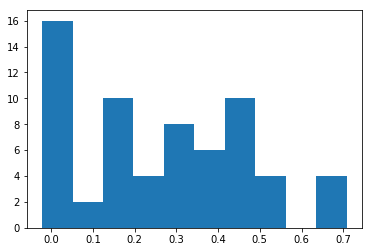

In [102]:
c = corrAll[:,:,1]
c[np.isinf(c)]=0
plt.hist(c.flatten())

## Hierarchical Clustering

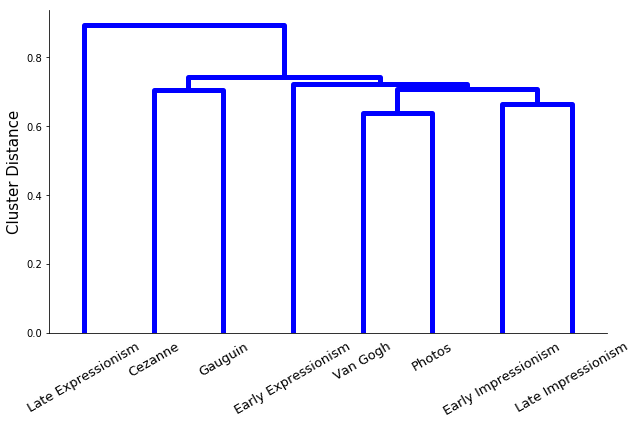

In [19]:
Z = linkage(analyze, 'average')
f, ax = plt.subplots(figsize=(9, 6))
plt.rcParams['lines.linewidth'] = 5

dn = dendrogram(Z,labels=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],orientation='top',leaf_font_size=15)
#ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
plt.xticks(rotation=30,fontsize=13)
plt.ylabel('Cluster Distance', fontsize=15)
#plt.title("Hierarchical Clustering of Correlations Between Fixations on Styles",fontsize=15)
sns.despine(left=False, bottom=False, right=True)
plt.tight_layout()
#plt.show()
plt.savefig('ResultsNew/StyleFixCorrClusterR.tiff')